# E2a: Küchentischversuch zum Laval-Rotor

Name: Julie Kickstein  
Datum: 09.01.2024

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:

Wie stark sind die durch Vibration hervorgerufenen Schwingungen eines Handys und eines Mixers?

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:
![Handy](handy.jpeg)
- Beschreibung des Aufbaus:
An den Pi ist der Beschleunigungssensor angeschlossen. Dieser wird auf das zu messende Objekt (hier Handy) gelegt und misst bei eingeschalteter Vibration deren Schwingungen.
- Vorgangsbeschreibung:
Die Vibration des Handys wird mittels einem an den Pi angeschlossenen Beschleunigungssensors gemessen. Dabei wird der Sensor  auf das Handy gelegt und bei angeschalter Vibration die Schwingungen für 20 Sekunden gemessen. Die Messungen wird durch runnen der acceleration_measurement.py gestartet und nach 20 Sekunden auch automatisch beendet. Automatisch wird eine HDF5 Datei mit den Messwerten abgespeichert.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [27]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft
from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [28]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = 'measurement_data'
h5_file_name = 'data_20240109_135607_JulieKickstein_handy' 
# ---------------------------------------------------------------------------------------------#1-end

In [29]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)
print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240109_140250_JulieKickstein_mixer/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240109_140250_JulieKickstein_mixer/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240109_140250_JulieKickstein_mixer/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeaee5f-a7de-6adb-b0a8-0cb7307535eb": {
    "type": "probe",
    "name": "mixer",
    "comment": "",
    "path": "measurement_data/

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [30]:
path = 'measurement_data/data_20240109_135607_JulieKickstein_handy/data_20240109_135607_JulieKickstein_handy.h5'
file = h5py.File(path, 'r') 
data = file['1ee847be-fddd-6ee4-892a-68c4555b0981']
time = np.array(data['timestamp'])
acceleration_x = np.array(data['acceleration_x'])
acceleration_y = np.array(data['acceleration_y'])
acceleration_z = np.array(data['acceleration_z'])
print(acceleration_x)
print(acceleration_y)
print(acceleration_z)

[-0.0784532 -0.0784532 -0.0784532 ...  0.2353596  0.2353596  0.2353596]
[-1.0983448 -1.0983448 -1.0983448 ... -0.8629852 -0.8629852 -0.8629852]
[9.022118  9.022118  9.022118  ... 8.3160392 8.3160392 8.3160392]


#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [31]:
acc_betrag = get_vec_accel(acceleration_x, acceleration_y, acceleration_z)
print(acc_betrag)

[9.08906648 9.08906648 9.08906648 ... 8.36400894 8.36400894 8.36400894]


#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

Text(0, 0.5, 'delta t')

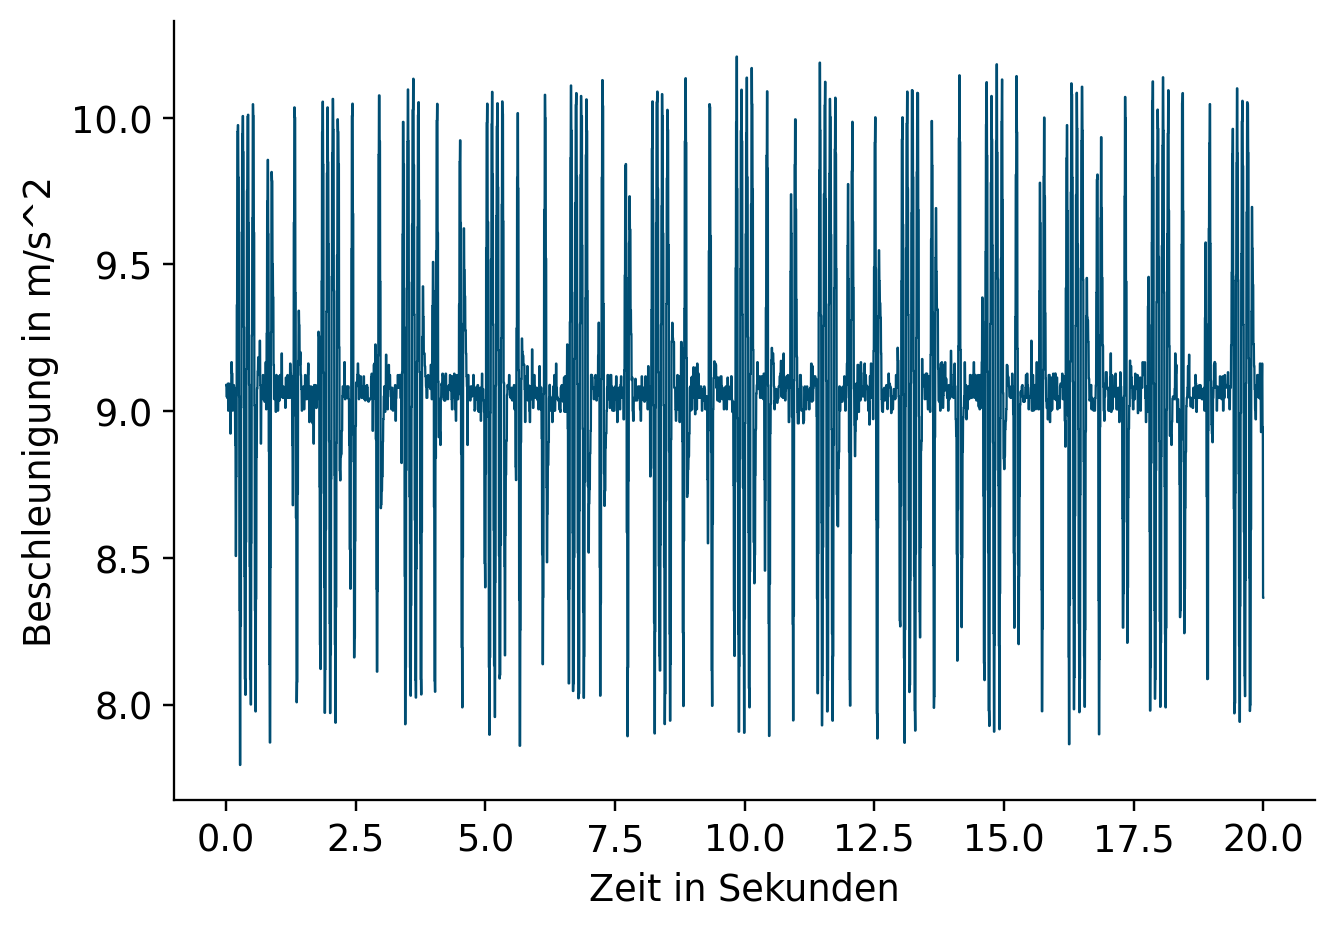

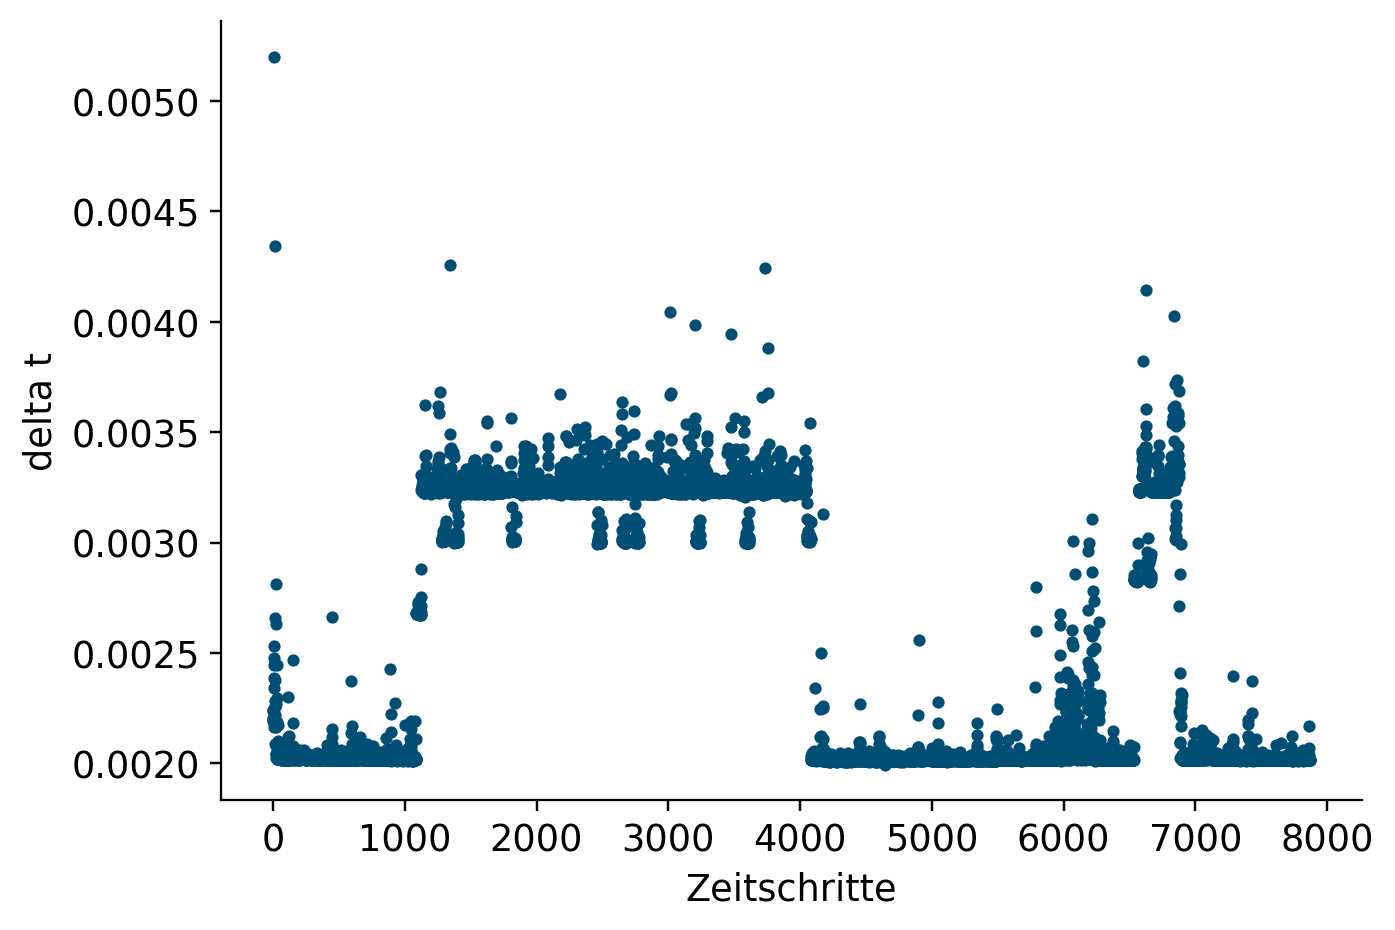

In [32]:
fig = plt.figure()
plt.plot(time, acc_betrag)
plt.xlabel('Zeit in Sekunden')
plt.ylabel('Beschleunigung in m/s^2')

delta_t_liste = []
for i in range(1, (len(time))):
    delta_t_liste.append(time[i] - time[i-1])
    
fig2 = plt.figure()
plt.plot(delta_t_liste, '.')
plt.xlabel('Zeitschritte')
plt.ylabel('delta t')


#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [33]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.

data_interp = interpolation(time, acc_betrag)
print(data_interp)

[9.08906648 9.08906648 9.07776879 ... 8.66634056 8.36400894 8.36400894]


#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

Text(0, 0.5, 'Amplitude')

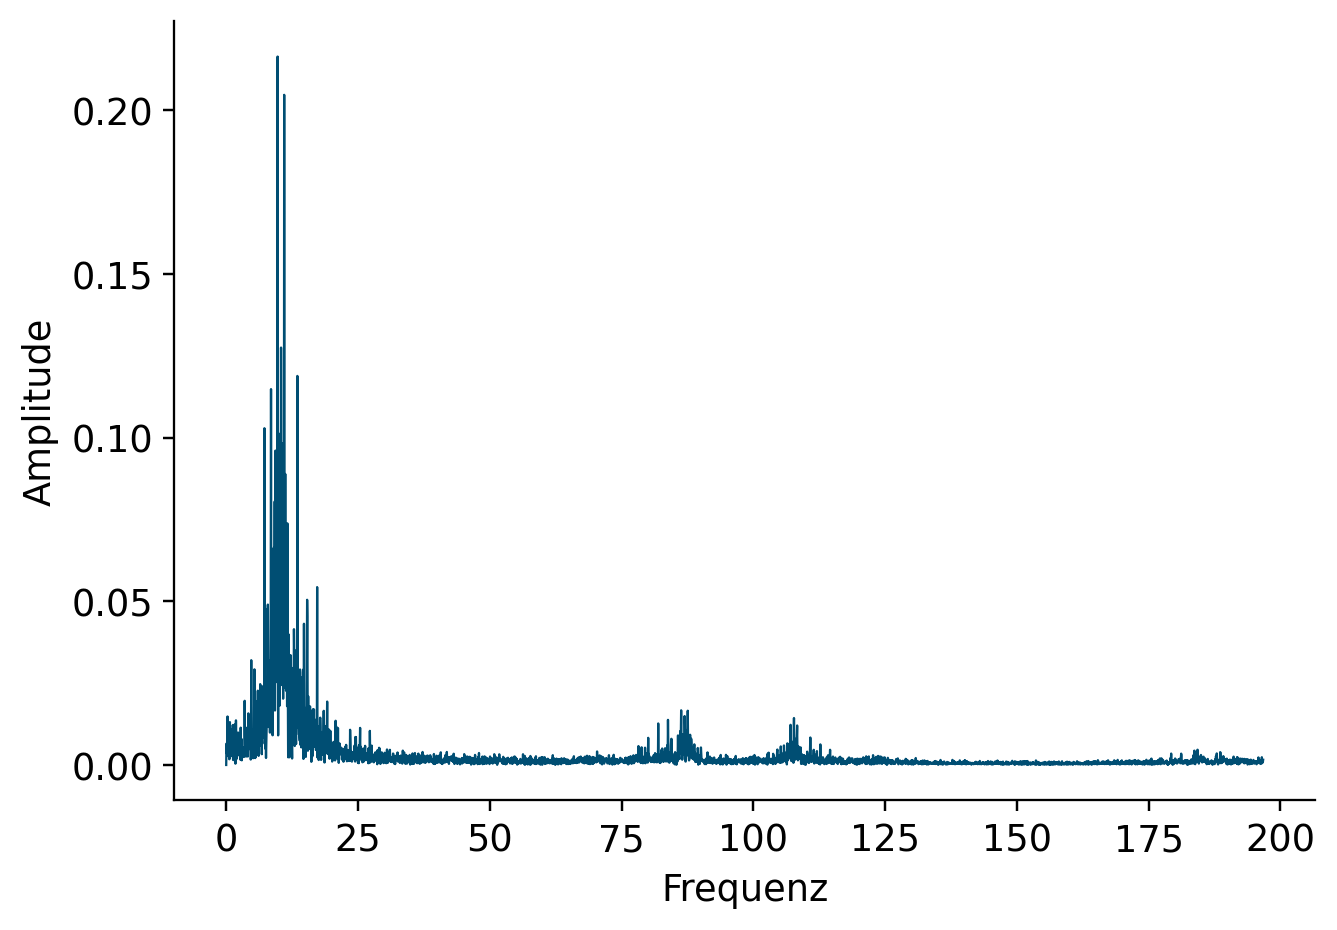

In [34]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

X_oneside, f_oneside = my_fft(data_interp, time)
fig2 = plt.figure()
plt.plot(f_oneside, np.abs(X_oneside))
plt.xlabel('Frequenz')
plt.ylabel('Amplitude')

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:
![Mixer](mixer.jpeg)

- Beschreibung des Aufbaus:
An den Pi ist der Beschleunigungssensor angeschlossen. Dieser wird auf das zu messende Objekt (hier Mixer) gelegt und misst bei eingeschalteter Vibration deren Schwingungen.
- Vorgangsbeschreibung:
Die Vibration des Handys wird mittels einem an den Pi angeschlossenen Beschleunigungssensors gemessen. Dabei wird der Sensor  auf den Mixer gelegt und bei angeschalter Vibration die Schwingungen für 20 Sekunden gemessen. Die Messungen wird durch runnen der acceleration_measurement.py gestartet und nach 20 Sekunden auch automatisch beendet. Automatisch wird eine HDF5 Datei mit den Messwerten abgespeichert.

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [35]:
path_measurement_folder = 'measurement_data' 
h5_file_name = 'data_20240109_140250_JulieKickstein_mixer.h5' 
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)
print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))

{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240109_140250_JulieKickstein_mixer/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240109_140250_JulieKickstein_mixer/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240109_140250_JulieKickstein_mixer/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeaee5f-a7de-6adb-b0a8-0cb7307535eb": {
    "type": "probe",
    "name": "mixer",
    "comment": "",
    "path": "measurement_data/

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [36]:
path = 'measurement_data/data_20240109_140250_JulieKickstein_mixer/data_20240109_140250_JulieKickstein_mixer.h5'

file = h5py.File(path, 'r')
data = file['1ee847be-fddd-6ee4-892a-68c4555b0981']
        
time = np.array(data['timestamp'])
acceleration_x = np.array(data['acceleration_x'])
acceleration_y = np.array(data['acceleration_y'])
acceleration_z = np.array(data['acceleration_z'])

#### 2. Betrag der Beschleunigung berechnen


In [37]:
acc_betrag = get_vec_accel(acceleration_x, acceleration_y, acceleration_z)
print(acc_betrag)

[ 5.93359865  5.93359865  5.93359865 ... 10.30995646 10.30995646
  8.23282139]


#### 3. Darstellung der Messdaten

Text(0, 0.5, 'delta t')

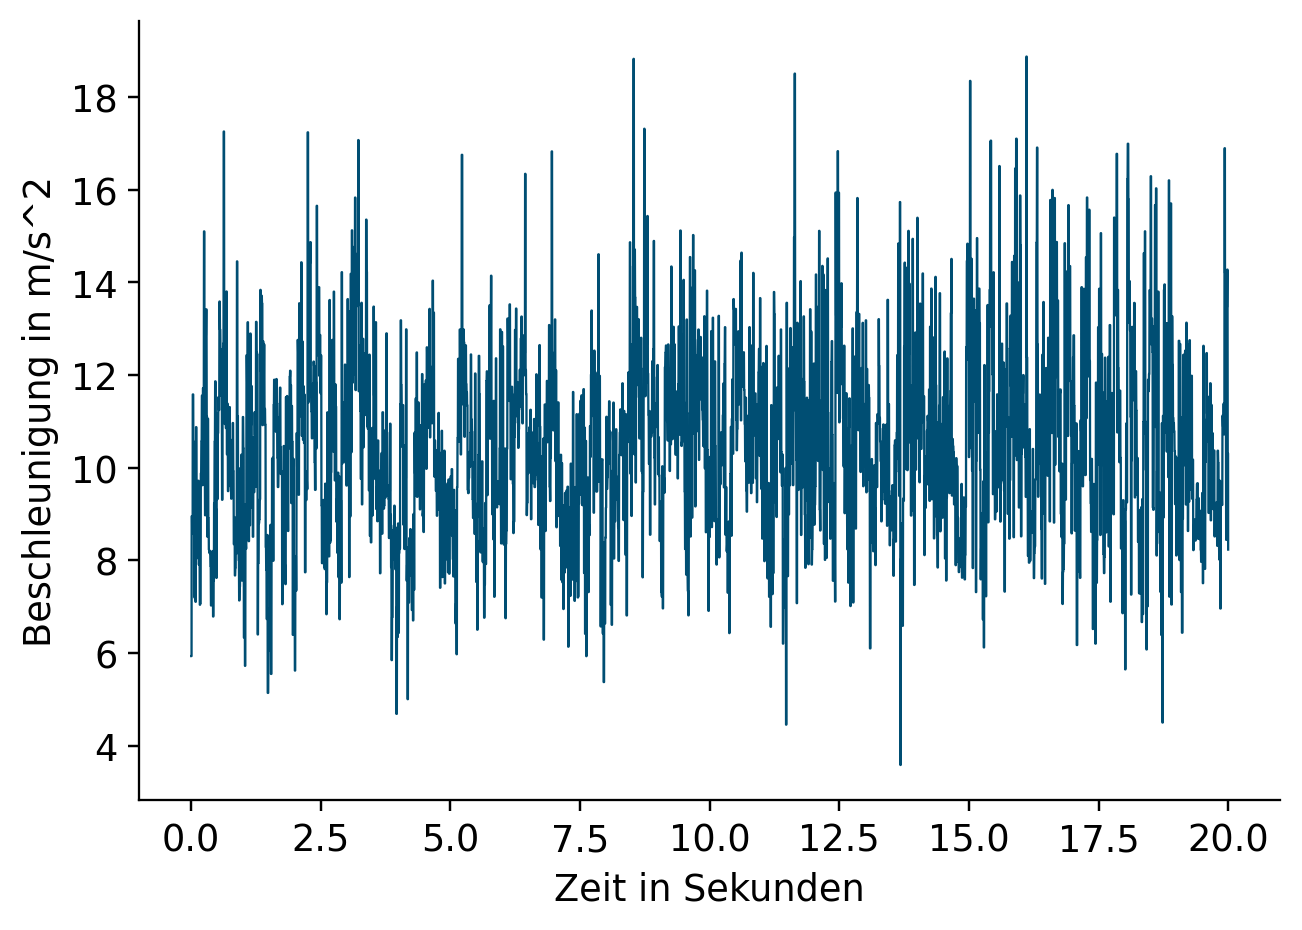

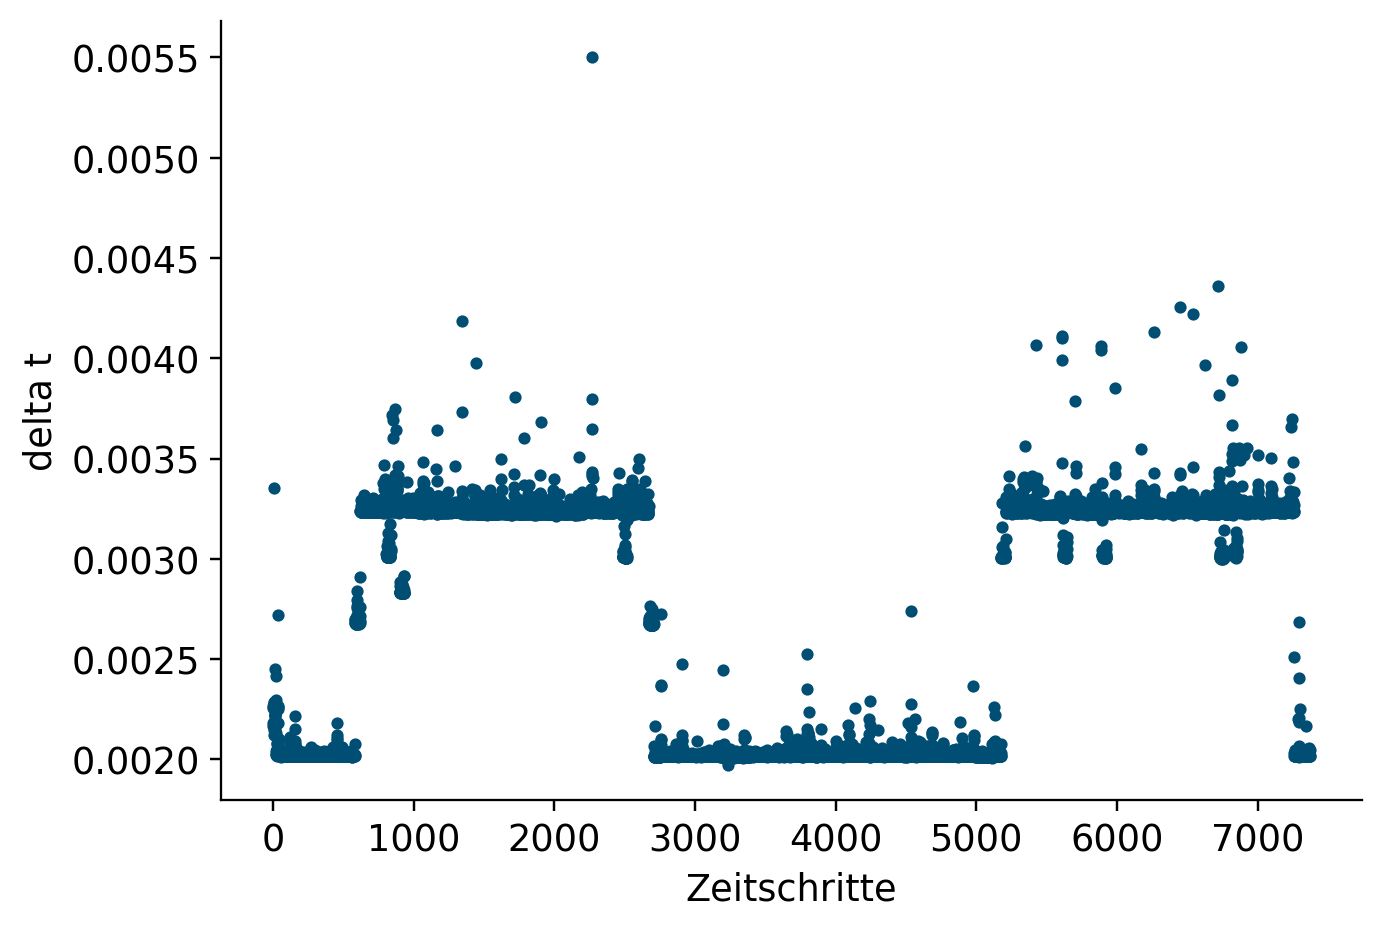

In [38]:
fig = plt.figure()
plt.plot(time, acc_betrag)
plt.xlabel('Zeit in Sekunden')
plt.ylabel('Beschleunigung in m/s^2')
delta_t_liste = []
for i in range(1, (len(time))):
    delta_t_liste.append(time[i] - time[i-1])
fig2 = plt.figure()
plt.plot(delta_t_liste, '.')
plt.xlabel('Zeitschritte')
plt.ylabel('delta t')


#### 4. Interpolation der Messwerte



In [39]:
data_interp = interpolation(time, acc_betrag)
print(data_interp)

[ 5.93359865  5.93359865  5.93359865 ... 10.30995646 10.30995646
  8.23282139]


#### 5 & 6. FFT durchführen und graphisch darstellen


Text(0, 0.5, 'Amplitude')

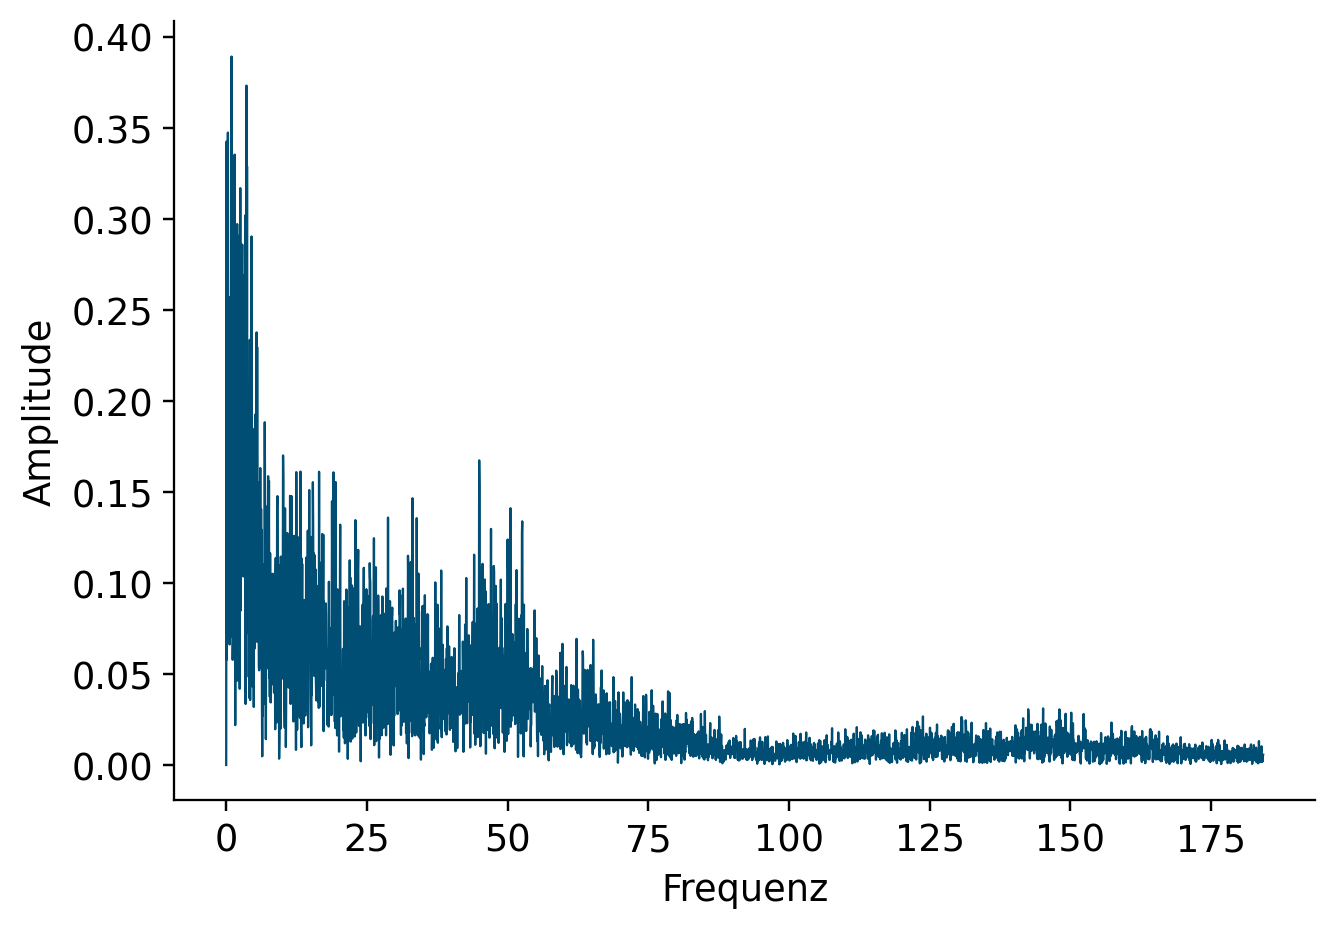

In [40]:
 X_oneside, f_oneside = my_fft(data_interp, time)
fig2 = plt.figure()
plt.plot(f_oneside, np.abs(X_oneside))
plt.xlabel('Frequenz')
plt.ylabel('Amplitude')


## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Die Beschleunigung des Mixers ist wie zu erwarten viel größer als die eines Handys, was an der größe der Amplituden zu erkennen ist. Außerdem ist die Beschleunigung beim Handy, durch ein beständiges Vibrationsmuster, regelmäßiger als die beim Mixer.
Außerdem ist auffällig, dass die Messabstände des Pis teilweise sehr unterschiedlich sind.Im Bereich zwischen 700-2700 Zeitschritten und zwischen 5200 und 7200 Zeitschritten liegen die Abstände deutlich höher, was die Daten verfälschen könnte. Allerdings ist in den Beschleunigungswerten keine klare Auswirkung davon zu erkennen, weshalb sich die höheren Messabschnitte wahrscheinlich nicht negativ auf die Messungen ausgewirkt haben. Der Pi ist somit immernoch geeignet für eine solche Art der Messung. Fazit

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.